In [1]:
import commonsetting
from models import perceptual_network, Encoder, Class_out, Conf_out
from dataloader import CustomImageDataset, concatenate_transform_steps
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch import nn
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd


def calculate_confidence_label(y_pred):
    if y_pred <= 1/3:
        y_pred = 0
    elif y_pred >= 2/3:
        y_pred = 1
    else:
        y_pred = 0.5

    return y_pred


if __name__ == "__main__":
    pretrained_model_name   = commonsetting.pretrained_model_name
    hidden_layer_size       = commonsetting.hidden_layer_size
    hidden_activation_name  = commonsetting.hidden_activation_name
    hidden_activation       = commonsetting.hidden_activation
    hidden_dropout          = commonsetting.hidden_dropout
    resize                  = commonsetting.image_resize
    in_shape                = (1,3,resize,resize)

    SimpleCNN_args = dict(
        pretrained_model_name   = pretrained_model_name,
        hidden_layer_size       = hidden_layer_size,
        hidden_activation       = hidden_activation,
        hidden_dropout          = hidden_dropout,
        hidden_layer_type       = commonsetting.hidden_layer_type,
        output_layer_size       = commonsetting.output_layer_size,
        in_shape                = (1,3,resize,resize),
        retrain_encoder         = commonsetting.retrain_encoder,
        device                  = commonsetting.device,
        )
        

    tranformer_steps = concatenate_transform_steps(image_resize=commonsetting.image_resize, rotate=0)

    dataset_val = CustomImageDataset(commonsetting.val_dir,label_map=commonsetting.label_map , transform=tranformer_steps)
    dataloader_test = DataLoader(dataset_val, batch_size=commonsetting.batch_size, shuffle=True, num_workers=commonsetting.num_workers)
    SimpleCNN = perceptual_network(**SimpleCNN_args)
    SimpleCNN.load_state_dict(torch.load("../models/simplecnn.h5"))
    for p in SimpleCNN.parameters(): p.requires_grad = False
    # define loss function
    classification_loss = nn.BCELoss()
    # when there is no noise
    SimpleCNN.eval()
    SimpleCNN.to(commonsetting.device)
    with torch.no_grad():
        # extract features of each image
        y_true = []
        y_pred = []
        y_correct_pred = []
        confidence_out = []
        for idx_batch, (batch_image, batch_label) in tqdm(enumerate(dataloader_test)):
            batch_label = torch.vstack(batch_label).T.float()
            #记得每一次处理数据之前要做这一步
            
            features,hidden_representation,prediction, confidence =  SimpleCNN(batch_image.to(commonsetting.device))
            correct_preds = batch_label.clone().detach().argmax(1)==prediction.clone().detach().argmax(1)
            correct_preds = correct_preds.float()

            correct_preds = torch.vstack([1-correct_preds, correct_preds]).T.float()
            
            
            y_correct_pred.append(correct_preds.detach().cpu().numpy())
            y_true.append(batch_label.detach().cpu().numpy())
            y_pred.append(prediction.detach().cpu().numpy())
            confidence_out.append(confidence.detach().cpu().numpy())
    
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_correct_pred = np.concatenate(y_correct_pred, axis=0)
    confidence_out = np.concatenate(confidence_out, axis=0)


/Users/zhengyuanrui/opt/anaconda3/envs/workspace/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1it [00:12, 12.50s/it]


In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [3]:
roc_auc_score(y_true, y_pred)

0.5883333333333334

In [4]:
roc_auc_score(y_correct_pred, confidence_out)

0.5601851851851851

In [5]:
y_pred.shape

(30, 3)

In [6]:
y_pred

array([[0.6014606 , 0.14806998, 0.25046948],
       [0.41671267, 0.34513202, 0.23815529],
       [0.47437614, 0.14896885, 0.37665498],
       [0.05675047, 0.00511016, 0.9381394 ],
       [0.72801566, 0.05499058, 0.21699369],
       [0.7750306 , 0.10721951, 0.11774988],
       [0.37068298, 0.559941  , 0.06937608],
       [0.46068147, 0.26688802, 0.27243048],
       [0.38077512, 0.03955689, 0.579668  ],
       [0.2809205 , 0.04314089, 0.6759386 ],
       [0.48659536, 0.38869396, 0.12471066],
       [0.28068498, 0.06685774, 0.65245736],
       [0.25506896, 0.16685079, 0.57808024],
       [0.09880001, 0.05880461, 0.8423954 ],
       [0.593714  , 0.06227618, 0.34400976],
       [0.29912218, 0.29169115, 0.40918666],
       [0.4996155 , 0.13778676, 0.3625978 ],
       [0.6162068 , 0.00314189, 0.38065135],
       [0.33089733, 0.00811437, 0.66098833],
       [0.4987528 , 0.00339611, 0.49785107],
       [0.60667133, 0.02130175, 0.3720269 ],
       [0.72131735, 0.15639825, 0.12228435],
       [0.

In [7]:
y_true

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [8]:
from matplotlib import pyplot as plt

(array([1., 0., 2., 1., 5., 4., 7., 3., 5., 2.]),
 array([0.28310716, 0.3429265 , 0.40274587, 0.46256521, 0.52238458,
        0.58220392, 0.64202327, 0.70184261, 0.76166201, 0.82148135,
        0.88130069]),
 <BarContainer object of 10 artists>)

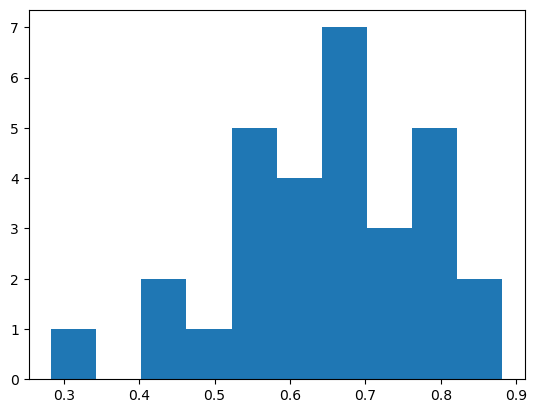

In [9]:
plt.hist(confidence_out[:,1])

In [10]:
confidence_out

array([[0.46121737, 0.5387826 ],
       [0.40212175, 0.5978783 ],
       [0.43999183, 0.56000817],
       [0.14363278, 0.8563672 ],
       [0.4441524 , 0.5558476 ],
       [0.18008101, 0.81991905],
       [0.23947032, 0.76052976],
       [0.56698763, 0.43301243],
       [0.40015736, 0.5998426 ],
       [0.35354027, 0.6464597 ],
       [0.30932608, 0.6906739 ],
       [0.32264134, 0.6773586 ],
       [0.29807323, 0.70192677],
       [0.28415665, 0.7158433 ],
       [0.52256364, 0.47743636],
       [0.38242704, 0.6175729 ],
       [0.5624406 , 0.43755937],
       [0.22320017, 0.77679986],
       [0.20191075, 0.79808927],
       [0.21690814, 0.78309184],
       [0.3387793 , 0.66122067],
       [0.11869922, 0.8813007 ],
       [0.30174482, 0.69825524],
       [0.32625836, 0.67374164],
       [0.376585  , 0.62341505],
       [0.43517935, 0.56482065],
       [0.44955403, 0.550446  ],
       [0.71689284, 0.28310716],
       [0.3231476 , 0.6768524 ],
       [0.21714309, 0.78285694]], dtype=flo

In [11]:
#the value is 1 to 0,below 0.5 is low confident, above is high confident

def calculate_confidence_rating(confidence_out):
    if confidence_out <= 1/2:
        confidence_out = 1
    else:
        confidence_out = 2

    return confidence_out
rating = ([calculate_confidence_rating(item) for item in confidence_out[:,1]])

In [12]:
response = y_pred[:,1]
correct_preds

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

In [13]:
y_pred

array([[0.6014606 , 0.14806998, 0.25046948],
       [0.41671267, 0.34513202, 0.23815529],
       [0.47437614, 0.14896885, 0.37665498],
       [0.05675047, 0.00511016, 0.9381394 ],
       [0.72801566, 0.05499058, 0.21699369],
       [0.7750306 , 0.10721951, 0.11774988],
       [0.37068298, 0.559941  , 0.06937608],
       [0.46068147, 0.26688802, 0.27243048],
       [0.38077512, 0.03955689, 0.579668  ],
       [0.2809205 , 0.04314089, 0.6759386 ],
       [0.48659536, 0.38869396, 0.12471066],
       [0.28068498, 0.06685774, 0.65245736],
       [0.25506896, 0.16685079, 0.57808024],
       [0.09880001, 0.05880461, 0.8423954 ],
       [0.593714  , 0.06227618, 0.34400976],
       [0.29912218, 0.29169115, 0.40918666],
       [0.4996155 , 0.13778676, 0.3625978 ],
       [0.6162068 , 0.00314189, 0.38065135],
       [0.33089733, 0.00811437, 0.66098833],
       [0.4987528 , 0.00339611, 0.49785107],
       [0.60667133, 0.02130175, 0.3720269 ],
       [0.72131735, 0.15639825, 0.12228435],
       [0.

In [14]:
from collections import Counter
Counter(y_correct_pred[:,1])

Counter({1.0: 12, 0.0: 18})

In [15]:
def response_good(y_pred):
    if y_pred == 1:
        y_pred = 1
    else:
        y_pred = 0

    return y_pred

In [16]:
y_pred_list = y_pred.argmax(1).tolist()

In [17]:
response = ([response_good(item) for item in y_pred_list])

In [18]:
data = {"stim":y_true[:,1].tolist(), "response":response, "rating":rating, "acc":y_correct_pred[:,1].tolist()}

In [19]:
df = pd.DataFrame(data)

In [20]:
df

,stim,response,rating,acc
0,0.0,0,2,1.0
1,0.0,0,2,0.0
2,1.0,0,2,0.0
3,0.0,0,2,1.0
4,1.0,0,2,0.0
5,1.0,0,2,0.0
6,0.0,1,2,0.0
7,0.0,0,1,0.0
8,1.0,0,2,0.0
9,1.0,0,2,0.0


In [21]:
df.to_csv("../data/sub/metad_CNN.csv")

In [22]:
df['rating'].value_counts()

2    26
1     4
Name: rating, dtype: int64

In [23]:
df['response'].value_counts()

0    26
1     4
Name: response, dtype: int64

In [24]:
df['stim'].value_counts()

0.0    20
1.0    10
Name: stim, dtype: int64

In [25]:
df['acc'].value_counts()

0.0    18
1.0    12
Name: acc, dtype: int64